In [36]:
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
BCS = 0.0
N_GRID_POINTS = 64
LAMBDA = 0.8
C_WAVE = 1.0  # wave speed c [m/s]
STEPS = 100
SHOT_LIST =  [50000]
BATCH_SIZE = 1
REPETITIONS = 3

USE_FAKE_HARDWARE = True
NOISE = False

L_left = -1.0
L_right = 1.0
assert L_right > L_left, "L_right must be greater than L_left"

import qiskit, qiskit_aer
from qiskit.circuit import Instruction
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeBrisbane


print("Qiskit / Aer:", qiskit.__version__, qiskit_aer.__version__)

#
# Quantum Simulator
#
backend_ref = FakeBrisbane()
noise_model = NoiseModel.from_backend(backend_ref)

Qiskit / Aer: 2.2.1 0.17.2


In [37]:
def provide_simulator(noise=False):
    if USE_FAKE_HARDWARE == False:
        return AerSimulator()
    else:
        sim = AerSimulator.from_backend(backend_ref)
        sim.set_options(noise_model=None)
        if noise:
            sim.set_options(noise_model=noise_model)
    return sim

def angle_from_prob(p: float) -> float:
    """Return θ = 2*arcsin(sqrt(p)) with clipping to [0,1]."""
    p = float(np.clip(p, 0.0, 1.0))
    return 2.0 * np.arcsin(np.sqrt(p))


def encode_signed_to_prob(u_val: float, M: float) -> float:
    """
    maps [-M, M] to [0, 1]
    """
    if M <= 0:
        return 0.5
    return float(np.clip(0.5 + 0.5 * (u_val / M), 0.0, 1.0))

def decode_prob_to_signed(p: float, M: float) -> float:
    return M * (2.0 * float(np.clip(p, 0.0, 1.0)) - 1.0)

def wave_weights(lam: float):
    """
    Four-term affine weights in the leapfrog update:
      E^{n+1}_i = aL*E_{i-1}^n + aC*E_i^n + aR*E_{i+1}^n + aP*E_i^{n-1}
    where aL=aR=lam^2, aC=2-2 lam^2, aP=-1. Sum = 1.
    """
    aL = lam**2
    aR = lam**2
    aC = 2.0 - 2.0 * lam**2
    aP = -1.0
    return aL, aC, aR, aP

# ---------- Classical (periodic) ----------
def laplacian_periodic(E: np.ndarray, dx: float) -> np.ndarray:
    return (np.roll(E, -1) - 2.0*E + np.roll(E, 1)) / (dx*dx)

def wave_first_step_taylor(E0: np.ndarray, dx: float, dt: float, c: float) -> np.ndarray:
    """
    E^1 = E^0 + dt * (dt E)(x,0) + 0.5 * (c*dt)^2 * E_xx(x,0).
    Exact dt E(x,0) = -c*pi*cos(pi*x)
    """
    n_points = E0.size
    x = np.linspace(-1.0, 1.0, n_points, endpoint=False)
    V0 = -c * np.pi * np.cos(np.pi * x)
    return E0 + dt * V0 + 0.5 * (c*dt)**2 * laplacian_periodic(E0, dx)

def wave_eq_one_step_classical(E_prev: np.ndarray, E_curr: np.ndarray, lam: float) -> np.ndarray:
    """
    Leapfrog explicit update with periodic BCs
    """
    aL, aC, aR, aP = wave_weights(lam)
    E_next = ( aL * np.roll(E_curr,  1) + aC * E_curr +
                aR * np.roll(E_curr, -1) + aP * E_prev )
    return E_next

# ---------- Quantum branching micro-kernel for wave ----------
def branching4_mk_instruction(pL, pC, pR, pP, lam, name="wave4_node") -> Instruction:
    """
    One 3-qubit subcircuit (s0, s1, ro) that realizes a 4-outcome selector with
    normalized weights:
        wL = lam^2/3, wC = (2 - 2*lam^2)/3, wR = lam^2/3, wP = 1/3
    and injects leaf probs:
        L: pL,  C: pC,  R: pR,  P: (1 - pP) 
    The measured Pr(ro=1) equals wL*pL + wC*pC + wR*pR + wP*(1 - pP).
    """
    # normalized weights
    wL = (lam**2) / 3.0
    wC = (2.0 - 2.0*lam**2) / 3.0
    wR = (lam**2) / 3.0
    wP = 1.0 / 3.0
    # group masses for a two-level binary tree: A={L,C}, B={R,P}
    gA = wL + wC
    gB = wR + wP

    # angles for selector
    theta0 = angle_from_prob(gB)                          # sets Pr(s0=1) = gB
    thetaA = angle_from_prob(0.0 if gA == 0 else wC/gA)   # Pr(s1=1 | s0=0) = wC/gA
    thetaB = angle_from_prob(0.0 if gB == 0 else wP/gB)   # Pr(s1=1 | s0=1) = wP/gB

    # leaf injection angles
    phiL = angle_from_prob(pL)
    phiC = angle_from_prob(pC)
    phiR = angle_from_prob(pR)
    phiPc = angle_from_prob(1.0 - pP)

    # 3 qubits: [s0, s1, ro]
    sub = QuantumCircuit(3, name=name)
    # Top split: A={L,C} vs B={R,P}
    sub.ry(theta0, 0)
    # Conditional split within A when s0=0
    sub.x(0); sub.cry(thetaA, 0, 1); sub.x(0)
    # Conditional split within B when s0=1
    sub.cry(thetaB, 0, 1)

    # --- leaf injections into ro ---
    # L: (s0=0, s1=0)
    sub.x(0); sub.x(1); sub.mcry(phiL, [0, 1], 2); sub.x(1); sub.x(0)
    # C: (s0=0, s1=1)
    sub.x(0); sub.mcry(phiC, [0, 1], 2); sub.x(0)
    # R: (s0=1, s1=0)
    sub.x(1); sub.mcry(phiR, [0, 1], 2); sub.x(1)
    # P: (s0=1, s1=1)
    sub.mcry(phiPc, [0, 1], 2)

    return sub.to_instruction()


def build_batch_wave_1kernel(E_prev: np.ndarray, E_curr: np.ndarray, lam: float,
                             start_idx: int, batch_size: int, M: float,
                             name="batch"):
    """
    Batch circuit: 3 qubits per node (s0, s1, ro), 1 classical bit per node.
    Uses the 4-leaf microkernel above. Returns (QuantumCircuit, node_indices).
    """
    n_points = E_curr.size
    nodes = list(range(start_idx, min(start_idx + batch_size, n_points)))
    mm = len(nodes)

    q = QuantumRegister(3 * mm, "q")
    c = ClassicalRegister(mm, "c")
    circ = QuantumCircuit(q, c, name=name)

    for j, i in enumerate(nodes):
        # periodic BCs
        im1 = (i - 1 + n_points) % n_points
        ip1 = (i + 1) % n_points

        # Encode to probabilities with a single shared scale M
        pL = encode_signed_to_prob(E_curr[im1], M)
        pC = encode_signed_to_prob(E_curr[i],   M)
        pR = encode_signed_to_prob(E_curr[ip1], M)
        pP = encode_signed_to_prob(E_prev[i],   M)

        inst = branching4_mk_instruction(pL, pC, pR, pP, lam, name=f"wave4_{i}")
        s0 = 3*j; s1 = s0 + 1; ro = s0 + 2
        circ.append(inst, [q[s0], q[s1], q[ro]])

    # Measure only the readout qubits
    ro_qubits = [q[3*j + 2] for j in range(mm)]
    circ.measure(ro_qubits, c[:mm])
    return circ, nodes

def one_step_wave_eq_batched(E_prev: np.ndarray, E_curr: np.ndarray, lam: float,
                             shots: int, batch_size: int, sim=None) -> np.ndarray:
    if sim is None:
        sim = provide_simulator()

    n_points = E_curr.size
    maxE = max(float(np.max(np.abs(E_curr))), float(np.max(np.abs(E_prev))), 1e-12)
        
    batches, idx_groups = [], []
    for start in range(0, n_points, batch_size):
        bc, nodes = build_batch_wave_1kernel(E_prev, E_curr, lam, start, batch_size, maxE, name=f"batch_{start}")
        batches.append(bc); idx_groups.append(nodes)

    tbatches = transpile(batches, backend=sim, optimization_level=3, seed_transpiler=42)
    result = sim.run(tbatches, shots=shots).result()

    def p1_from_counts(counts, m, j):
        tot = 0
        for s, n in counts.items():
            s = s.zfill(m)
            if s[::-1][j] == '1':
                tot += n
        return tot / shots
    
    p_meas = np.zeros(n_points)
    for k, nodes in enumerate(idx_groups):
        counts = result.get_counts(k)
        m = len(nodes)
        for j, i in enumerate(nodes):
            p_meas[i] = p1_from_counts(counts, m, j)

    # E^{n+1} = M * (6*p_meas - 3)
    E_next = maxE * (6.0 * p_meas - 3.0)
    return E_next

def get_circuit_info(E_prev: np.ndarray, E_curr: np.ndarray, lam: float, batch_size: int, sim=None):
    if sim is None:
        sim = provide_simulator()

    n_points = E_curr.size
    maxE = max(float(np.max(np.abs(E_curr))), float(np.max(np.abs(E_prev))), 1e-12)
        
    batches, idx_groups = [], []
    for start in range(0, n_points, batch_size):
        bc, nodes = build_batch_wave_1kernel(E_prev, E_curr, lam, start, batch_size, maxE,name=f"batch_{start}")
        batches.append(bc); idx_groups.append(nodes)

    tbatches = transpile(batches, backend=sim, optimization_level=3, seed_transpiler=42)

    metrics = []
    for k, qc in enumerate(tbatches):
        # Basic info
        n_qubits  = qc.num_qubits
        n_clbits  = qc.num_clbits
        size      = qc.size()                 # total instructions
        depth     = qc.depth()                # includes measure/barrier
        depth_nom = qc.depth(                 # ignore measure/barrier
            filter_function=lambda inst: inst.operation.name not in ("measure", "barrier")
        )
        ops = qc.count_ops() 
        metrics.append({
            "batch": k,
            "name": qc.name,
            "nodes": list(idx_groups[k]),
            "n_qubits": n_qubits,
            "n_clbits": n_clbits,
            "size": size,
            "depth": depth,
            "depth_no_meas": depth_nom,
            "ops": dict(ops)
        })

    # Print metrics
    for m in metrics:
        print(
            f"{m['name']}: depth={m['depth']} (no-meas {m['depth_no_meas']}), "
            f"size={m['size']}, qubits={m['n_qubits']}, operations={m['ops']}")


In [38]:
def wave_test(N=N_GRID_POINTS, steps=STEPS, CFL=LAMBDA, c=C_WAVE,
              shots_list=SHOT_LIST, repetitions=REPETITIONS,
              batch_size=BATCH_SIZE, noise=NOISE):
    """
    Periodic grid on [-1,1), IC E(x,0)=sin(pi x), exact E(x,t)=sin(pi x - c*pi t).
    Compares quantum update to classical explicit leapfrog.
    """

    u_noise = None

    sim = provide_simulator(noise=noise)

    # periodic grid
    x = np.linspace(L_left, L_right, N, endpoint=False)
    dx = (L_right - L_left) / N
    dt = CFL * dx / c # [s]
    lam = CFL  # = c*dt/dx

    time_array = np.zeros(steps)

    print(f"\nWave test: N={N}, steps={steps}, dx={dx:.6g}, dt={dt:.6g}, c={c}, CFL={lam:.3f}")

    E0 = np.sin(np.pi * x)
    E1 = wave_first_step_taylor(E0, dx, dt, c)
    E_prev_q,  E_curr_q  = E0.copy(), E1.copy()
    get_circuit_info(E_prev_q, E_curr_q, lam, batch_size=batch_size, sim=sim)

    time_array = np.zeros(steps)

    profiles = {}
    L_inf_tot = []
    L2_tot = []

    all_errors = {}
    all_profiles_time = {}

    for ss in shots_list:
        L2 = []
        L_inf = []

        Linf_vec = []
        L2_vec = []

        for r in range(repetitions):
            # IC
            E0 = np.sin(np.pi * x)
            E1 = wave_first_step_taylor(E0, dx, dt, c)

            # copies for classical and quantum feeds
            E_prev_ref, E_curr_ref = E0.copy(), E1.copy()
            E_prev_q,  E_curr_q  = E0.copy(), E1.copy()
            print(f"Wave: shots={ss}, rep={r+1}/{repetitions}")

            u_time_matrix = np.zeros((steps, N))
            u_time_analytic_matrix = np.zeros((steps, N))

            for n in range(1, steps):
                print("Step ", n, "/",steps)
                # classical
                E_next_ref = wave_eq_one_step_classical(E_prev_ref, E_curr_ref, lam)
                # quantum
                E_next_q = one_step_wave_eq_batched(E_prev_q, E_curr_q, lam, shots=ss, batch_size=batch_size, sim=sim)

                u_time_matrix[n, :] = E_next_q
                u_time_analytic_matrix[n, :] = E_next_ref

                E_prev_ref, E_curr_ref = E_curr_ref, E_next_ref
                E_prev_q,  E_curr_q  = E_curr_q,  E_next_q

                time_array[n] += n*dt / repetitions

            # exact at T = steps*dt
            T = steps * dt
            E_exact = np.sin(np.pi * x - c * np.pi * T)

            diff = E_curr_q - E_exact
            linf = np.max(np.abs(diff))
            l2 = np.sqrt(np.mean(diff**2))
            L_inf.append(linf)
            L2.append(l2)

            diff_matrix = u_time_matrix - u_time_analytic_matrix
            linf_vec = np.max(np.abs(diff_matrix), axis=1)
            l2_vec = np.sqrt(np.mean(diff_matrix**2, axis=1))
            Linf_vec.append(linf_vec)
            L2_vec.append(l2_vec)

            if r == 0:
                profiles[ss] = (x.copy(), E_curr_ref.copy(), E_curr_q.copy(), E_exact.copy(), T)
                all_profiles_time[ss] = (u_time_matrix.copy(), u_time_analytic_matrix.copy())

            
        L_inf_tot.append(L_inf)
        L2_tot.append(L2)
        print(f"{ss:<9d} {np.mean(L_inf):.4f} ± {np.std(L_inf):.4f}  {np.mean(L2):.4f} ± {np.std(L2):.4f}")
    
        # print("\nWave eq - errors")
        # print("\nshots M    L_inf (mean ± std)    L2 (mean ± std)")
        # for i, ss in enumerate(shots_list):
        #     L_inf = L_inf_tot[i]
        #     L2 = L2_tot[i]
        #     print(f"{ss:<9d} {np.mean(L_inf):.4f} ± {np.std(L_inf):.4f}  {np.mean(L2):.4f} ± {np.std(L2):.4f}")
 
        Linf_vec = np.array(Linf_vec)
        L2_vec = np.array(L2_vec)
        mean_L_inf_time = np.mean(Linf_vec, axis=0)
        std_L_inf_time = np.std(Linf_vec, axis=0)
        mean_L2_time = np.mean(L2_vec, axis=0)
        std_L2_time = np.std(L2_vec, axis=0)

        all_errors[ss] = {
            'mean_L_inf_time': mean_L_inf_time,
            'std_L_inf_time': std_L_inf_time,
            'mean_L2_time': mean_L2_time,
            'std_L2_time': std_L2_time
        }

    return {
        'x': x,
        'u_analytic': E_exact,
        'profiles_for_plot': profiles,
        'all_profiles_time': all_profiles_time,
        'all_errors': all_errors,
        'time': time_array,
        'shots_list': shots_list,
        'steps': steps,
        'u_noise': u_noise
    }

convergence_results = wave_test(N=N_GRID_POINTS, steps=STEPS, shots_list=SHOT_LIST,
              repetitions=REPETITIONS, batch_size=BATCH_SIZE, noise=NOISE)



Wave test: N=64, steps=100, dx=0.03125, dt=0.025, c=1.0, CFL=0.800
batch_0: depth=346 (no-meas 346), size=534, qubits=127, operations={'rz': 263, 'sx': 172, 'ecr': 82, 'x': 16, 'measure': 1}
batch_1: depth=350 (no-meas 350), size=538, qubits=127, operations={'rz': 265, 'sx': 174, 'ecr': 82, 'x': 16, 'measure': 1}
batch_2: depth=349 (no-meas 349), size=537, qubits=127, operations={'rz': 264, 'sx': 174, 'ecr': 82, 'x': 16, 'measure': 1}
batch_3: depth=347 (no-meas 347), size=535, qubits=127, operations={'rz': 262, 'sx': 174, 'ecr': 82, 'x': 16, 'measure': 1}
batch_4: depth=348 (no-meas 348), size=536, qubits=127, operations={'rz': 263, 'sx': 174, 'ecr': 82, 'x': 16, 'measure': 1}
batch_5: depth=350 (no-meas 350), size=538, qubits=127, operations={'rz': 265, 'sx': 174, 'ecr': 82, 'x': 16, 'measure': 1}
batch_6: depth=347 (no-meas 347), size=535, qubits=127, operations={'rz': 262, 'sx': 174, 'ecr': 82, 'x': 16, 'measure': 1}
batch_7: depth=349 (no-meas 349), size=537, qubits=127, operatio

In [39]:
# system Tau for waves

tau = (L_right - L_left) / C_WAVE 
# here since we have periodic boundary conditions they concide

print(f"System time scales for Wave equation:")
print(f"  Hyperbolic time scale: tau = {tau:.4g} s")

System time scales for Wave equation:
  Hyperbolic time scale: tau = 2 s


<>:29: SyntaxWarning: invalid escape sequence '\i'
<>:29: SyntaxWarning: invalid escape sequence '\i'
/var/folders/9f/_xx5w7bj79b0pd_wr2l27y000000gn/T/ipykernel_92304/3951716770.py:29: SyntaxWarning: invalid escape sequence '\i'
  plt.plot(time_plot, mean_L_inf_time, label="$L_\infty$", color='blue', linewidth=2)


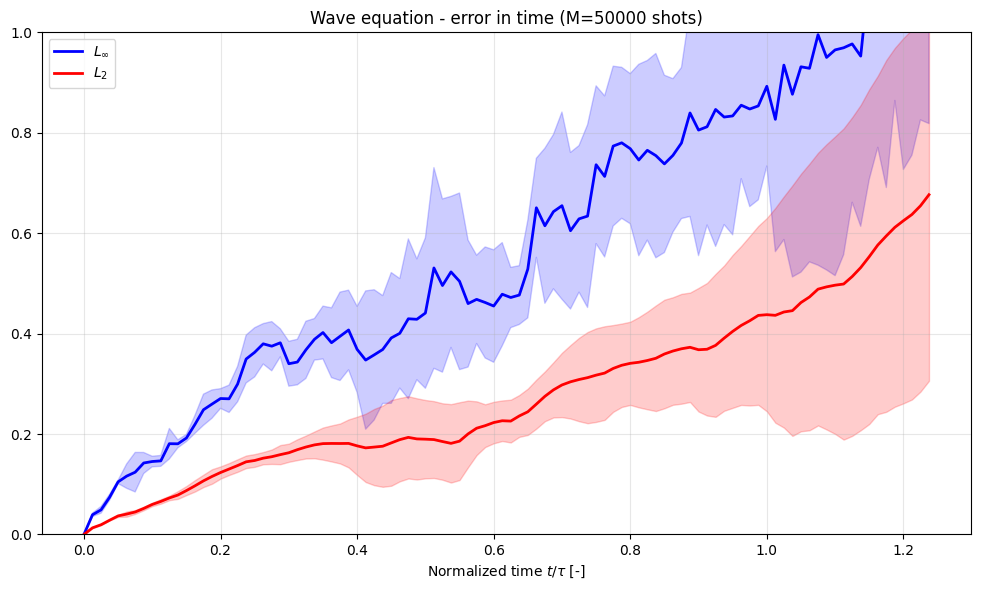

In [ ]:
# plot on time_step
# plot on physical normalized time "t/tau"

normalize_time = True
physical_time = False

for ss in convergence_results['shots_list']:
    errors = convergence_results['all_errors'][ss]
    mean_L_inf_time = errors['mean_L_inf_time']
    std_L_inf_time = errors['std_L_inf_time']
    mean_L2_time = errors['mean_L2_time']
    std_L2_time = errors['std_L2_time']
    steps = convergence_results['steps']

    if normalize_time:
        time_array = convergence_results['time']
        time_plot = time_array / tau
        string = "Normalized time $t / \\tau$ [-]"
    elif physical_time:
        time_plot = convergence_results['time']
        string = "Physical time $t$ [s]"
    else:
        time_plot = range(1, steps+1)
        string = "Time steps"

    plt.figure(figsize=(10, 6))
    plt.title(f"Wave equation - error in time (M={ss} shots)")
    plt.xlabel(f"{string}")
    plt.plot(time_plot, mean_L_inf_time, label="$L_\infty$", color='blue', linewidth=2)
    plt.fill_between(time_plot, mean_L_inf_time - std_L_inf_time, 
                     mean_L_inf_time + std_L_inf_time, alpha=0.2, color='blue')
    plt.plot(time_plot, mean_L2_time, label="$L_2$", color='red', linewidth=2)
    plt.fill_between(time_plot, mean_L2_time - std_L2_time, 
                     mean_L2_time + std_L2_time, alpha=0.2, color='red')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.ylim([0, 1.2])
    plt.show()

<Figure size 1200x700 with 0 Axes>

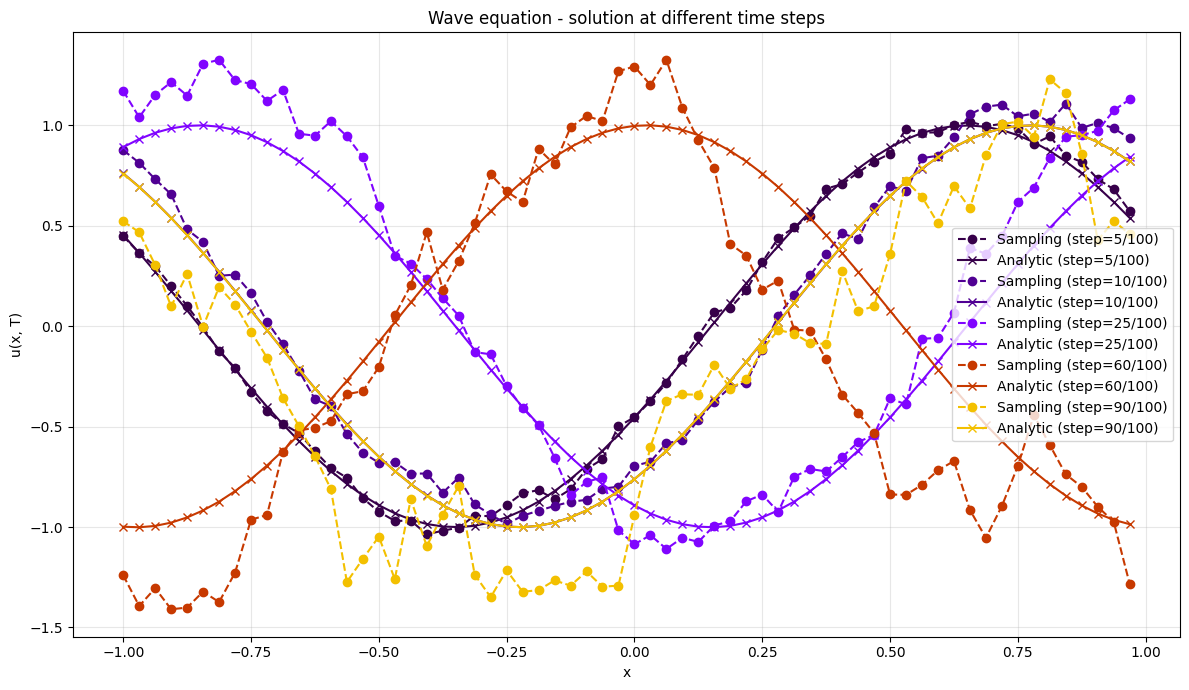

In [ ]:
percentage_list = [5, 10, 25, 60, 90]

x = convergence_results['x']
shots_list = convergence_results['shots_list']

# Use first shot configuration for illustration
for ss in convergence_results['shots_list']:
    # u_time_matrix, u_time_analytic_matrix = convergence_results['all_profiles_time'][ss]

    data = convergence_results['all_profiles_time'].get(ss, None)
    if data is not None:
        u_time_matrix, u_time_analytic_matrix = data
    else:
        print(f"No profile data for shots={ss}, skipping plot.")
        continue
    
    steps = convergence_results['steps']

    colorlist = plt.cm.gnuplot(np.linspace(0, 1, steps))
    plt.figure(figsize=(12, 7))
    plt.figure(figsize=(12, 7))
    for percentage in percentage_list:
        step = int(round((percentage / 100) * steps))
        plt.plot(x[:], u_time_matrix[step, :], color=colorlist[step], linestyle='--', 
                marker="o", label=f"Sampling (step={step}/{steps})")
        plt.plot(x[:], u_time_analytic_matrix[step, :], color=colorlist[step], 
                marker="x", label=f"Classical (step={step}/{steps})")
    plt.xlabel("x")
    plt.ylabel("u(x, T)")
    plt.title(f"Wave equation - solution at different time steps")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

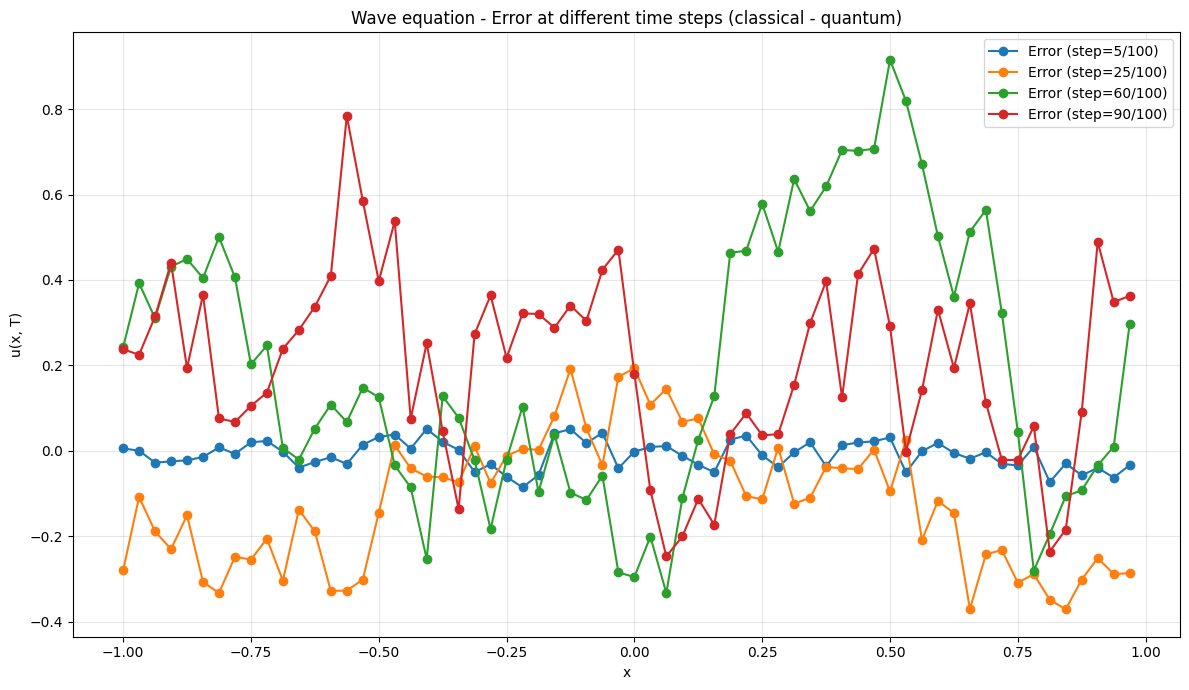

In [47]:
x = convergence_results['x']
shots_list = convergence_results['shots_list']
M = shots_list[0]
u_time_matrix, u_time_analytic_matrix = convergence_results['all_profiles_time'][M]
steps = convergence_results['steps']

# colorlist = plt.cm.gnuplot(np.linspace(0, 1, steps))
plt.figure(figsize=(12, 7))
for percentage in percentage_list:
    step = int(round((percentage / 100) * steps))
    plt.plot(x[:], u_time_analytic_matrix[step, :]- u_time_matrix[step, :], 
             marker="o", label=f"Error (step={step}/{steps})")
plt.xlabel("x")
plt.ylabel("u(x, T)")
plt.title(f"Wave equation - Error at different time steps (classical - quantum)")
# plt.plot(x[:], np.sinc((4*x)-2) * 0.3, linestyle='--', color='black', label="Sync reference")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# plt.ylim([-0.15, 0.15])
plt.show()

In [43]:
# plot u_noise
u_noise = convergence_results['u_noise']

if u_noise is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(x[:], u_noise[:], marker='o', linestyle='--', label="u_noise")
    plt.xlabel("x")
    plt.ylabel("u_noise")
    plt.title(f"Noise component after filtering (CUTOFF={CUTOFF})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()